In [1]:
import os
import torch
import cv2
import numpy as np
import pandas as pd
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
import datetime
import shutil

from utils.utils import apply_heatmap, grad_cam
from utils.get_model import get_model

now = datetime.datetime.now().strftime("%m%d_%H%M")
if torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

/Users/jeongseung-yeon/miniconda3/envs/skin/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 개별 이미지 Grad_CAM 확인

In [2]:
def get_last_layer(model, model_name):
    if model_name == "efficientb0":
        # efficient
        layer_name = model._blocks[-1]

    # swin_transformer
    elif model_name.lower() == 'swin_transformer':
        layer_name = model.layers[-1].blocks

    # ConvNext
    elif model_name.lower() == 'convnext':
        layer_name = model.stages[-1].blocks

    # MobileNet
    elif model_name.lower() == 'mobile':
        layer_name = model.features[-1]

    # fpn swin
    elif model_name.lower() == 'fpn_swin':
        layer_name = model.fpn.layer_blocks[-1]

    # hybrid
    elif model_name.lower() == 'hybrid':
        layer_name = model.convnext.features.get_submodule("7.2.block.0")

    return layer_name

In [ ]:
# def save_grad(model_name, dataset, df, target_imgs):
#     if os.path.exists(f'./img/grad_cam/{model_name}'):
#         shutil.rmtree(f'./img/grad_cam/{model_name}')
#     os.makedirs(f'./img/grad_cam/{model_name}', exist_ok=True)

#     for target_img in target_imgs:
#         try:
#             img_path = os.path.join(dataset, 'test', target_img)

#             # 모델 로드
#             true_label = df[df['image']==target_img]['true_label'].values[0]

#             predicted_label = df[df['image']==target_img]['predicted_label'].values[0]
#             num_classes = df['true_label'].nunique()

#             # model, layer_name, activation = get_model(model_name, num_classes) 
#             model, _ = get_model(model_name, num_classes) 
#             model.load_state_dict(torch.load(f'./save_weights/{saved_model}', map_location='cpu'))
#             model = model.to(device)

#             layer_name = get_last_layer(model, model_name)

#             transform = transforms.Compose([
#                 transforms.Resize((224, 224)),
#                 transforms.ToTensor()
#             ])

#             if saved_model_name.lower().__contains__('vit'):
#                 img_tensor = feature_extractor(images=Image.open(img_path).convert('RGB'), return_tensors="pt").pixel_values.to(device)
#             else:
#                 img_tensor = transform(Image.open(img_path).convert('RGB')).to(device)


#             # layer_name = dict(model.named_modules())["_conv_head"] # efficientb0 한정

#             # Grad-CAM 이미지 생성
#             heatmap = grad_cam(model, img_tensor, layer_name)
#             original_img = cv2.imread(img_path)
#             grad_cam_img = apply_heatmap(original_img, heatmap)

#             fig, axes = plt.subplots(1, 2, figsize=(15, 15))
#             axes[0].imshow(cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB))
#             axes[0].set_title(f'Original Image (Label: {true_label})')
#             axes[0].axis('off')

#             # 원본 이미지와 Grad-CAM 이미지를 시각화
#             try: 
#                 axes[1].imshow(cv2.cvtColor(grad_cam_img, cv2.COLOR_BGR2RGB))
#             except:
#                 grad_cam_img = (grad_cam_img * 255).astype(np.uint8)
#                 axes[1].imshow(cv2.cvtColor(grad_cam_img, cv2.COLOR_BGR2RGB))

#             # axes[1].set_title(f'Models: {model_name} | Grad-CAM Image (Label: {predicted_label})')
#             axes[1].axis('off')

#             # plt.suptitle(f'Model: {model_name}, Weights: {saved_model_time}, Image: {target_img}', fontsize=16)
#             # plt.tight_layout()
#             plt.savefig(f'./img/grad_cam/{model_name}/{target_img.split(".")[0]}.png')

#             # plt.show()
#             plt.close()
            
#         except Exception as e:
#             # print("Exception Error: ", e)
#             continue

In [ ]:
def save_grad_only(model_name, dataset, df, target_imgs, saved_model_name):
    
    if os.path.exists(f'./img/grad_cam_only/{model_name}'):
        shutil.rmtree(f'./img/grad_cam_only/{model_name}')
    os.makedirs(f'./img/grad_cam_only/{model_name}', exist_ok=True)

    for target_img in target_imgs:
        try:
            img_path = os.path.join(dataset, 'test', target_img)

            # 모델 로드
            true_label = df[df['image']==target_img]['true_label'].values[0]

            predicted_label = df[df['image']==target_img]['predicted_label'].values[0]
            num_classes = df['true_label'].nunique()

            # model, layer_name, activation = get_model(model_name, num_classes) 
            model, _ = get_model(model_name, num_classes) 
            model.load_state_dict(torch.load(f'./save_weights/{saved_model}', map_location='cpu'))
            model = model.to(device)

            layer_name = get_last_layer(model, model_name)

            transform = transforms.Compose([
                transforms.Resize((224, 224)),
                transforms.ToTensor()
            ])

            if saved_model_name.lower().__contains__('vit'):
                img_tensor = feature_extractor(images=Image.open(img_path).convert('RGB'), return_tensors="pt").pixel_values.to(device)
            else:
                img_tensor = transform(Image.open(img_path).convert('RGB')).to(device)

            # Grad-CAM 이미지 생성
            heatmap = grad_cam(model, img_tensor, layer_name)
            original_img = cv2.imread(img_path)
            grad_cam_img = apply_heatmap(original_img, heatmap)

            plt.figure(figsize=(6, 6))
            try: 
                plt.imshow(cv2.cvtColor(grad_cam_img, cv2.COLOR_BGR2RGB))
            except:
                grad_cam_img = (grad_cam_img * 255).astype(np.uint8)
                plt.imshow(cv2.cvtColor(grad_cam_img, cv2.COLOR_BGR2RGB))

            # plt.title(f'Models: {model_name} | Grad-CAM Image (Label: {predicted_label})')
            plt.axis('off')
            plt.subplots_adjust(left=0, right=1, top=1, bottom=0)

            # plt.suptitle(f'Model: {model_name}, Weights: {saved_model_time}, Image: {target_img}', fontsize=16)
            # plt.tight_layout()
            plt.savefig(f'./img/grad_cam_only/{model_name}/{target_img.split(".")[0]}.png')

            # plt.show()
            plt.close()
            
        except Exception as e:
            # print("Exception Error: ", e)
            continue

In [27]:
dataset = "data/ISIC_2019"
saved_model_root_path='./save_weights/'

for weights in os.listdir(saved_model_root_path):
    if not weights.startswith('0827') and weights.endswith('.pt'): continue

    saved_model = weights
    model_name = "_".join(saved_model.split('.')[0].split("_")[2:])
    saved_model_time = "_".join(saved_model.split('.')[0].split("_")[:2])
    saved_model_name = "".join(saved_model.split('.')[0].split("_")[2:])

    results_file = f"{weights.split('.pt')[0]}_results.csv"

    df = pd.read_csv(os.path.join("results", results_file), header=2)
    target_imgs = os.listdir("./data/ISIC_2019/test")[:16]        

    print(f"############## Processing model {model_name} ##############")
    # save_grad(model_name, dataset, df, target_imgs)
    # print("Grad-CAM images saved for model:", model_name)
    save_grad_only(model_name, dataset, df, target_imgs, saved_model_name)
    print("Grad-CAM only images saved for model:", model_name)
    print('\n')

############## Processing model hybrid ##############
Grad-CAM only images saved for model: hybrid


############## Processing model efficientb0 ##############
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Loaded pretrained weights for efficientnet-b0
Grad-CAM only images saved for model: efficientb0


############## Processing model fpn_swin ##############
Grad-CAM only images saved for model: fpn_swin


############## Processing model convnext ##############
Grad-CAM only images saved fo

In [ ]:
# Original Image 복사
# os.makedirs(f'./img/target_orig_imgs', exist_ok=True)

# for i in target_imgs:
#     shutil.copy(f'./data/ISIC_2019/test/{i}', f'./img/target_orig_imgs/{i}')

## Comapre

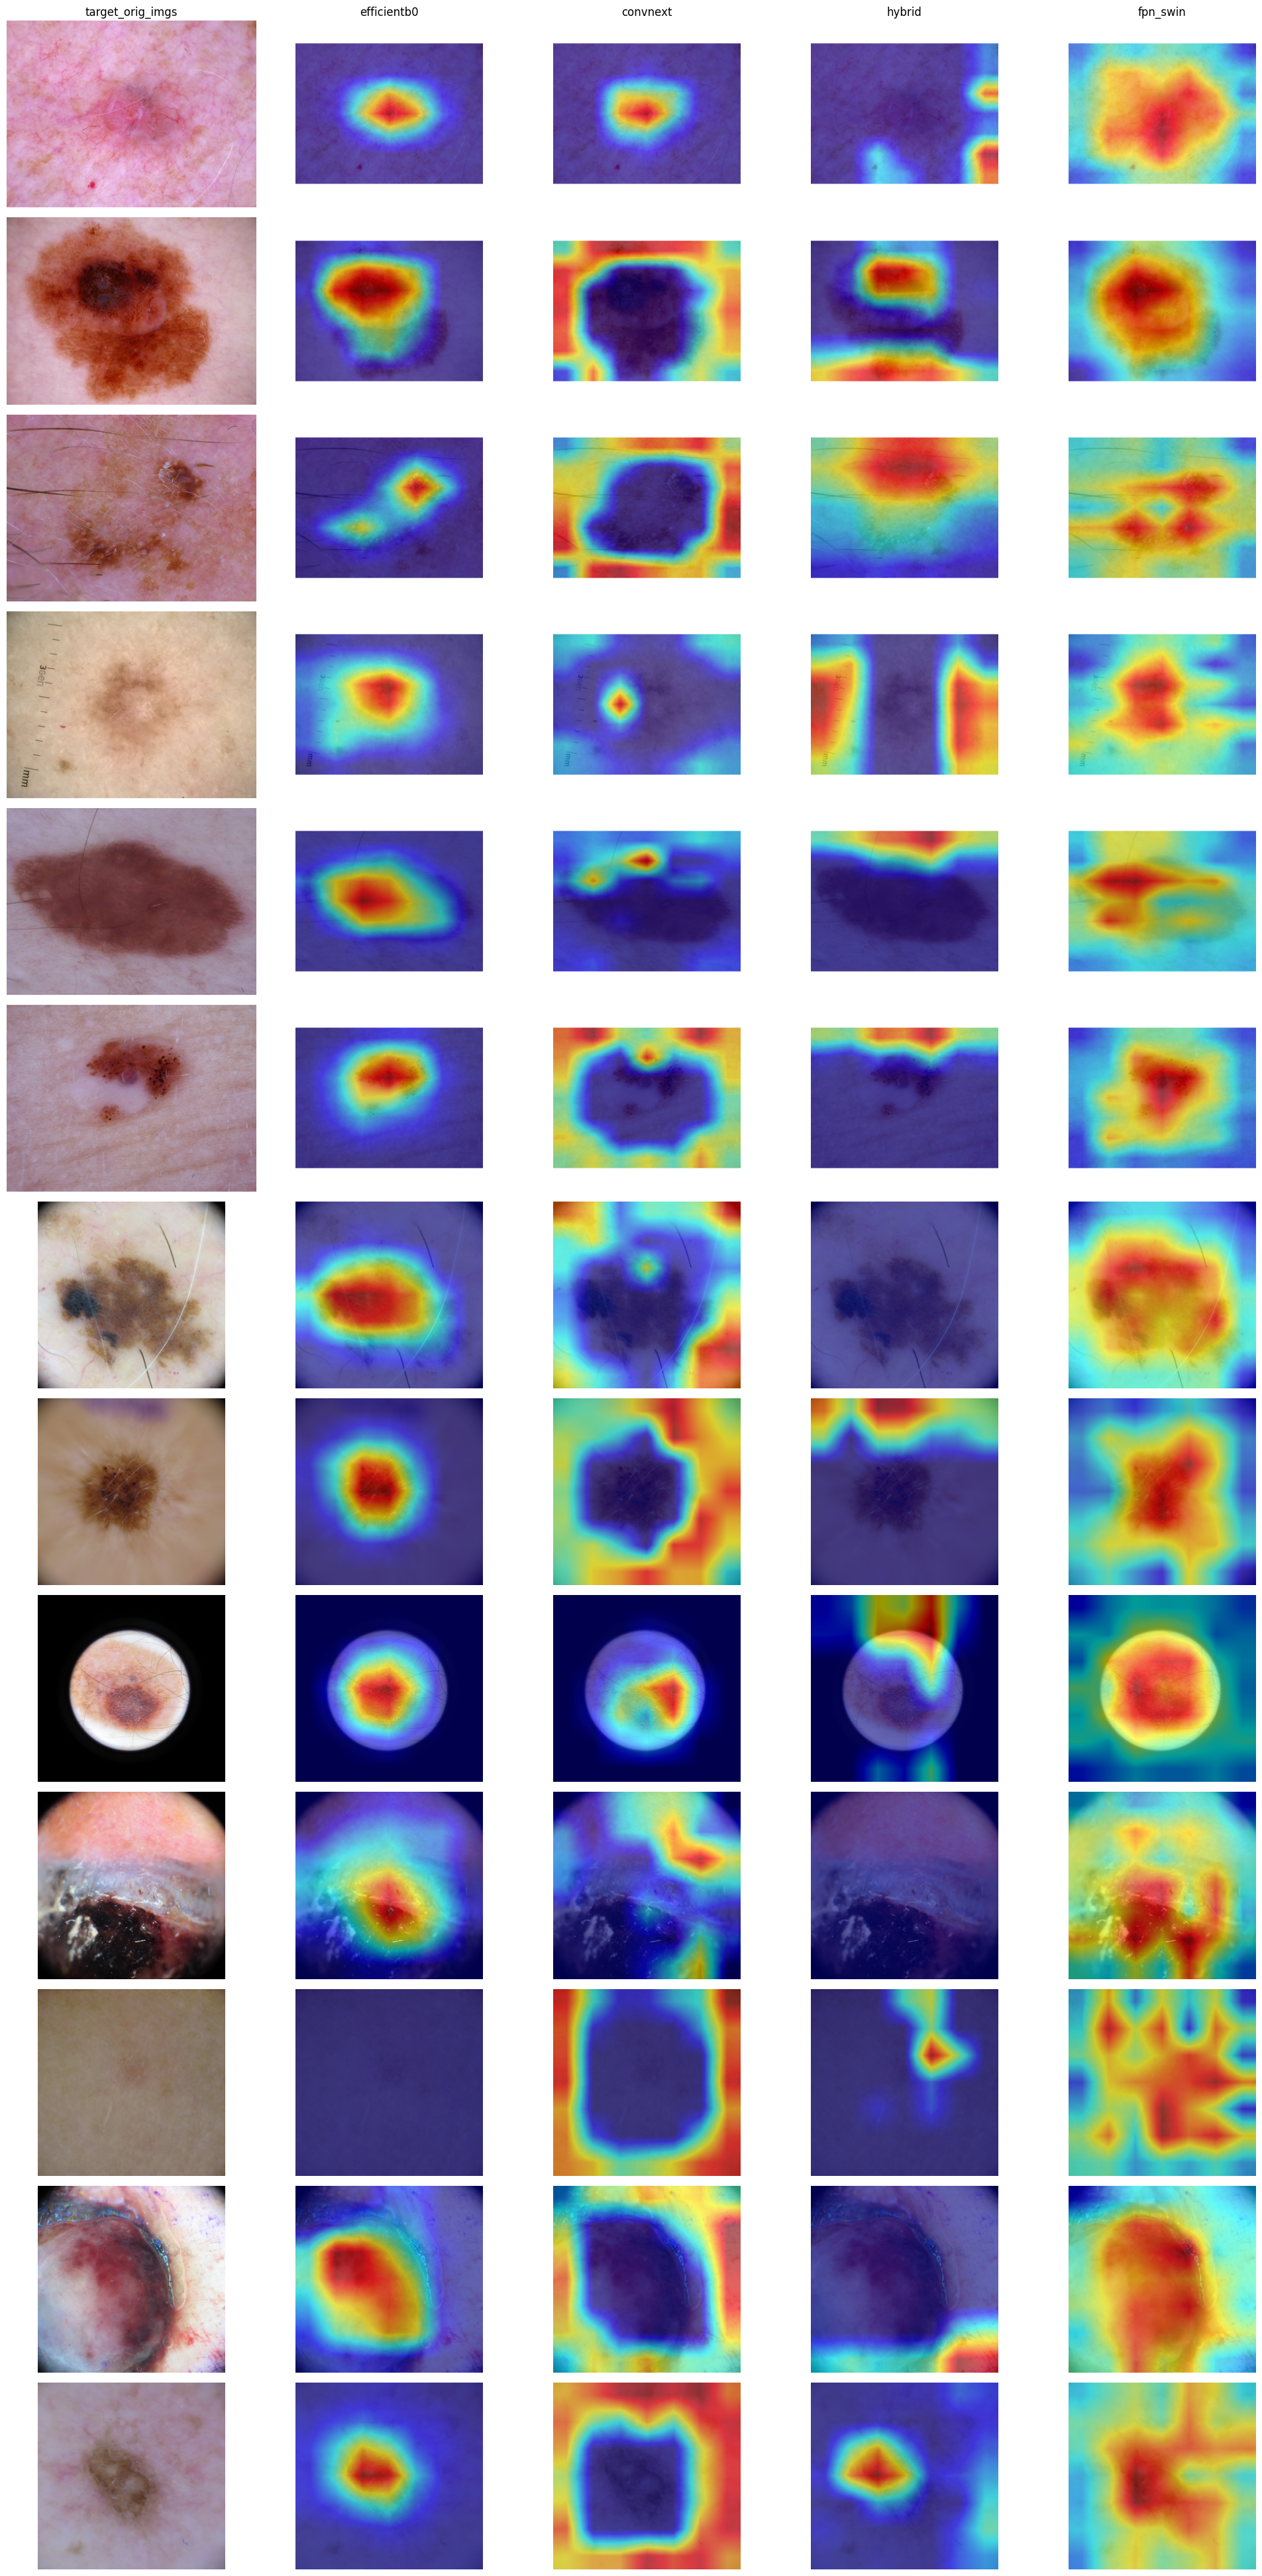

In [28]:
import os
import matplotlib.pyplot as plt
import cv2

base_path = "./img/grad_cam_only"
folders = ["target_orig_imgs", "efficientb0", "convnext", "hybrid", "fpn_swin"]

# 각 폴더의 이미지 파일 리스트 (정렬해서 이름 맞추기)
img_lists = [sorted(os.listdir(os.path.join(base_path, f))) for f in folders]

# 모든 폴더에서 같은 개수의 이미지가 있다고 가정
num_imgs = len(img_lists[0])

fig, axes = plt.subplots(num_imgs, len(folders), figsize=(20, num_imgs*3))

for i in range(num_imgs):
    for j, folder in enumerate(folders):
        img_path = os.path.join(base_path, folder, img_lists[j][i])
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)

        axes[i, j].imshow(img)
        axes[i, j].axis("off")
        if i == 0:  # 첫 행에만 제목
            axes[i, j].set_title(folder, fontsize=12)

plt.tight_layout()
plt.show()